# CART

In this notebook we give a take on the CART algorithm used to train decision trees. The aim of the notebook is to understand how the learning of the tree happens. To do so, we write a highly-recursive, high-memory class `RTree` that fits a decision tree.

The objective function for a _greedy_ decision tree model is given by $(i, j)$ such that 

$$
    \min_{i, j}\left[\sum_{\{i | x_i \in R_1(j, s)\}}(y_i - \hat c_1)^2 + \sum_{\{i | x_i \in R_2(j, s)\}}(y_i - \hat c_2)^2\right]
$$

Where,

$$
    \hat c_k = \frac{1}{N_k}\sum_{\{n|x_n\in R_k(j, s)\}} x_n
$$

That is, our search algorithm's goal is to find, for each input dimension $j$, the value $s$ that minimizes the error term

> Tree based models work by partitioning the input space into cuboid regios, whose edges are aligned with the axes, and then **assigning model** to each region

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed, multivariate_normal
from matplotlib import style
from tree import Node

In [2]:
%config InlineBackend.figure_format = "retina"
style.use("seaborn-white")
plt.rcParams.update({'font.size': 15})

In [3]:
import warnings
class RTree:
    def __init__(self, X, y, depth):
        """
        X: Numpy array
            Dataset of shape (N, K)
        y: Numpy array
            Dataset of shape (N,)
        """
        super().__init__()
        self.X = X
        self.y = y
        self.left = None
        self.right = None
        self.info = None
        self.depth = depth
        self.trained_subtree = False
    
    @property
    def nterminal_nodes(self):
        return 2 ** self.depth
        
    def fit(self):
        pass
    
    def _prune(self):
        pass
    
    def predict(self, x):
        pass
    
    def fit_subtrees(self):
        """
        Fit the current node of the tree, i.e., store at
        self.info (s, E, j) (cutoff point, error term, input dimension)
        and prepare the left and right subtree to be fit.
        
        If self.depth == 0 we stop the recursive process.
        Meaning we've reached a terminal node
        """
        self.find_min_err()
        s, _, j = self.info
        # Elements belonging to R1
        R1 = self.Ri(j, s)
        yR1 = self.y[R1]
        XR1 = self.X[R1, :]
        # Elements belonging to R2
        R2 = ~R1
        yR2 = self.y[R2]
        XR2 = self.X[R2, :]
        
        # Stop splitting the input dimension if there is no element
        # inside a region
        empty_subset = True if len(yR1) < 1 or len(yR2) < 1 else False
        if not empty_subset and self.depth >= 1:
            self.left = RTree(XR1, yR1, self.depth - 1)
            self.right = RTree(XR2, yR2, self.depth - 1)

            self.left.fit_subtrees()
            self.right.fit_subtrees()

    
    def find_min_err(self):
        """
        For the current subtree, find the cutoffpoint s'
        the error term that minimizes the criteria and
        the input dimension j that results in the lowest
        mean of squares error.
        """
        if not self.trained_subtree:
            # cutoff point, error value, dim
            dimerr = [(*self._min_err_j(j), j) for j in range(self.X.shape[1])]
            self.info = min(dimerr, key=lambda v: v[1])
            self.data = "*"
            self.trained_subtree = True
        else:
            warnings.warn("Subtree already trained. You can find the cutoffpoint, err, j at RTree.data")
        
    def _min_err_j(self, j):
        """
        Considering the j-th input dimension of our traning dataset,
        find the cutoff point s' such that minimizes the objetive error function
        
        Returns
        -------
        (float, float):
            Return a tuple with two elements: the optimal cutoffpoint s'
            and the error value when evaluating self.Ri(j, s')
        """
        Xj = self.X[:, j]
        smin, smax = Xj.min(), Xj.max() * 0.99
        sdom = np.linspace(smin, smax, 100)
        sprime_tuple = min([(s, self.E(j, s)) for s in sdom], key=lambda v: v[1])
        # cutoff point, error value
        return sprime_tuple
        
    def Ri(self, j, s):
        """
        Compute whether each of the observations belong to either
        R1 or R2.
        We assign an observation x to be in R1 if x_j <= s; otherwise we
        assign it to R2. In other words, we define Ri ⊆ X as:
            
        R1 = {x | x_j <= s};
        R2 = X - R1
        
        Note that the negative of the function, i.e., ~self.Ri(j, s)
        will return true for which values in the training dataset belong
        to R2. 
        
        Parameters
        ----------
        j: int
            the j-th input dimension of X
        s: float
            cutoff point
        
        Returns
        -------
        np.array(N,) of dtype bool:
            Return a boolean numpy array of the training dataset
            for which traning examples belong to R1.
        """
        return self.X[:, j] <= s
    
    @staticmethod
    def RSS(y):
        """
        Compute the mean residual sum of squares error
        
        Parameters
        ----------
        y: np.array(N,)
        
        Returns
        -------
        float: mean residual error
        """
        rss = 0 if len(y) == 0 else np.mean((y - y.mean()) ** 2)
        return rss
    
    def E(self, j, s):
        """
        Compute the objective error function for a decision tree model
        considering an index j in [0, .., D -1] and a cutoff point s.

        Parameters
        ----------
        j: int
            The dimension to evaluate
        s: float
            The cutoff point
        """
        yR1 = self.y[self.Ri(j, s)] # Elements belonging to R1
        yR2 = self.y[~self.Ri(j, s)] # Elements belonging to R2
        return self.RSS(yR1) + self.RSS(yR2)

In [4]:
seed(314)
D1 = multivariate_normal([-1 , 1], np.identity(2) * 0.2, 50)
D2 = multivariate_normal([ 1 ,-1], np.identity(2) * 0.2, 50)
D3 = multivariate_normal([-1 ,-1], np.identity(2) * 0.2, 50)
D4 = multivariate_normal([ 1,  1], np.identity(2) * 0.2, 50)
y1 = np.random.randn(50) + 3
y2 = np.random.randn(50) - 4
y3 = np.random.randn(50) - 8
y4 = np.random.randn(50) + 10

D = np.r_[D1,D2, D3, D4]
y = np.r_[y1, y2, y3, y4]

Under this first version of the `RTree` class, we can fit a depth-2 regression tree as follows:

In [5]:
tree = RTree(D, y, 2)
tree.fit_subtrees()

For a depth-2 regression treee we have

In [6]:
tree.nterminal_nodes

4

Under `tree.data`, we can find the cutoff point, the error term and the objetive dimension:

In [7]:
tree.info

(0.16861316808986837, 22.428994493267734, 1)

The results above show that, for a depth-1 tree, the _locally_ optimum cutoffpoint would be at around `0.17` along the y-axis. If a new observation `x` were to be such that its second entry is less than `0.17` (`x[1] <= 0.17`), we estimate a value `yhat` of 

In [8]:
tree.left.y.mean()

-5.748803773471802

On the other hand, if `x[1] > 0.17`, we estimate `yhat` as

In [9]:
tree.right.y.mean()

6.476684221043483


> Tree based model can be viewed as a model combination method in which only one model is responsible for making predictions at any given point in input space

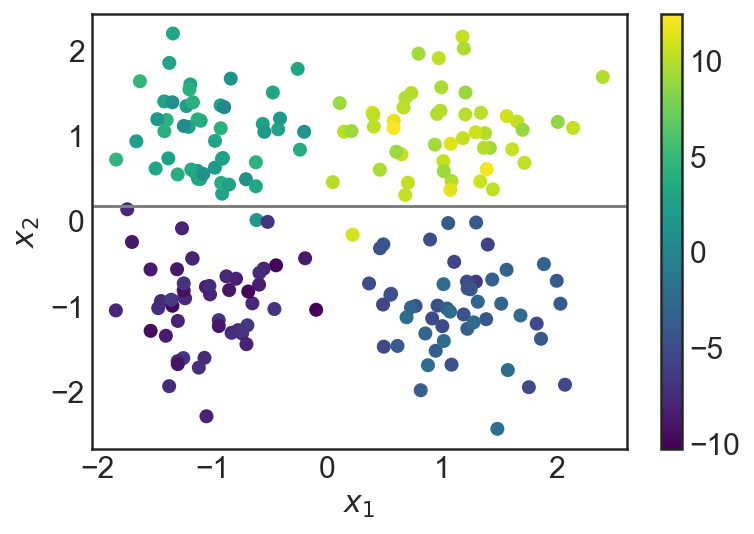

In [10]:
plt.scatter(*D.T, c=y, cmap="viridis")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axhline(y=tree.info[0], c="tab:gray")
plt.colorbar()

For a depth-2 regression tree (as in this example), and given a new observation `x`. From its first level we know that the first cutoffpoint happens at its second dimension with value `0.17`.

If `x[1] <= 0.17` then we consider the **second** cutoffpoint 

In [11]:
tree.left.info

(-0.07028726517232764, 8.397848955410351, 0)

The second cutoff point, for `x[1] <= 0.17`, happens that the first input dimension at around `-0.07`.  
Hence, for `x[1] <= 0.17 and x[0] <= -0.07`, we estimate `yhat` as

In [12]:
tree.left.left.y.mean()

-7.8150199660642

On the other hand, for `x[1] <= 0.17 and x[0] > -0.07` we estimate `yhat` as 

In [13]:
tree.left.right.y.mean()

-3.6825875808794066

Similarly for `x[1] > 0.17 and x[0] <= -0.07` we have

In [14]:
tree.right.left.y.mean()

2.8574605757872753

And finally, for `x[1] > 0.17 and x[0] > -0.07` we have

In [15]:
tree.right.right.y.mean()

10.095907866299692

Thus partitioning $\mathbb{R}^2$ as follows:

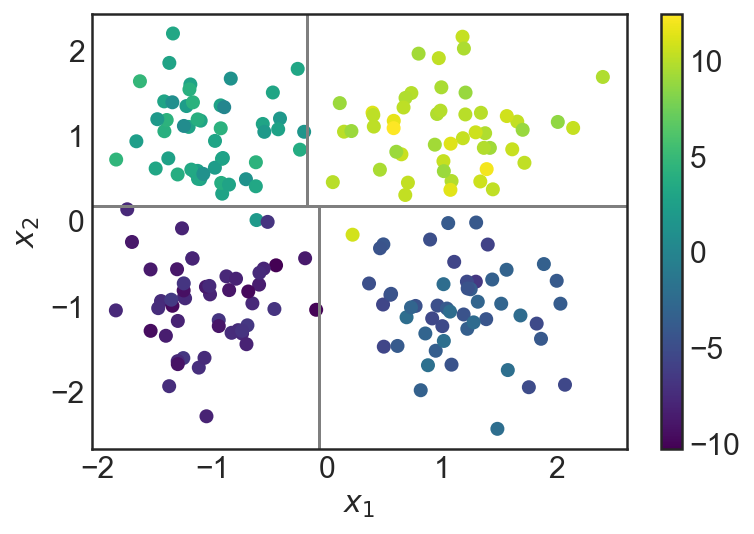

In [16]:
plt.scatter(*D.T, c=y, cmap="viridis")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

ymin, ymax = plt.ylim()
plt.axhline(y=tree.info[0], c="tab:gray")
plt.vlines(x=tree.left.info[0], ymin=ymin, ymax=tree.info[0], color="tab:gray")
plt.vlines(x=tree.right.info[0], ymin=tree.info[0], ymax=ymax, color="tab:gray")
plt.ylim(ymin, ymax)
plt.colorbar()

## `RTree` so far

In [17]:
rtree = RTree(D, y, 4)
rtree.fit_subtrees()

A helper function to count the number of terminal nodes inside a non-pruned tree

In [18]:
def _count_terminal_nodes(subtree, hist=""):
    if subtree.left is None and subtree.right is None:
        print(hist)
        return 1
    # we've reached a left terminal node; we continue on the
    # left branch
    elif subtree.left is None:
        return _count_terminal_nodes(subtree.right, hist=hist+"R")
    # we've reached a right terminal node; we continue on the
    # right branch
    elif subtree.right is None:
        return _count_terminal_nodes(subtree.left, hist=hist+"L")
    else:
        return _count_terminal_nodes(subtree.left, hist=hist+"L") + \
               _count_terminal_nodes(subtree.right, hist=hist+"R")

In [19]:
class Tree(Node):
    def __init__(self, data=None):
        super().__init__(data)
        
tree = Tree("*")
tree.left = Tree("L")
tree.left.right = Tree("LR")
tree.left.left = Tree("LL")
tree.left.left.left = Tree("LLL")
tree.left.left.right = Tree("LLR")

tree.right = Tree("R")
tree.right.left = Tree("RL")
tree.right.left.right = Tree("RLR")
tree.right.left.left = Tree("RLL")
tree.right.right = Tree("RR")
tree.right.right.left = Tree("RRL")

In [20]:
_count_terminal_nodes(tree)

LLL
LLR
LR
RLL
RLR
RRL


6

In [21]:
tree.prettyPrint()

          ______*______ 
         /             \
      __L__           __R__ 
     /     \         /     \
   LL      LR      RL      RR 
   / \             / \     /  
 LLL LLR         RLL RLR RRL    

In [22]:
_count_terminal_nodes(rtree)

LLL
LLR
LRL
LRRL
LRRR
RLL
RLRL
RLRR
RRLL
RRLR
RRR


11

In [23]:
class RTreev2(RTree, Node):
    def __init__(self, X, y, depth):
        RTree.__init__(self, X, y, depth)
        Node.__init__(self)
    
    def fit_subtrees(self):
        super().fit_subtrees()

In [24]:
trv2 = RTreev2(D, y, 4)
trv2.fit_subtrees()

In [25]:
trv2.prettyPrint()

                  ______________*______________ 
                 /                             \
          ______*______                   ______*______ 
         /             \                 /             \
      __*__           __*__           __*__           __*__ 
     /     \         /     \         /     \         /     \
    *       *       *       *       *       *       *       * 
                           / \             / \     / \        
                          *   *           *   *   *   *         

## Tree Pruning
In order to ahieve tree pruning, we consider another helper function that computes the MSE averaged over all nodes.

In [26]:
def leaf_func(subtree, f):
    """
    Apply a cummulative function f applied over all
    leaf (terminal) nodes
    """
    if subtree.left is None and subtree.right is None:
        return f(subtree)
    # we've reached a left terminal node; we continue on the
    # left branch
    elif subtree.left is None:
        return leaf_func(subtree.right, f)
    # we've reached a right terminal node; we continue on the
    # right branch
    elif subtree.right is None:
        return leaf_func(subtree.left, f)
    else:
        return leaf_func(subtree.left, f) + \
               leaf_func(subtree.right, f)

In [27]:
part_mse = lambda subtree: subtree.info[1] * len(subtree.y)
count = lambda subtree: 1
count_samples = lambda subtree: len(subtree.y)

In [28]:
depths = range(2, 15)
tree_mse = []
mean_samples = []
for depth in depths:
    tree = RTree(D, y, depth)
    tree.fit_subtrees()
    mse = leaf_func(tree, part_mse) / len(y)
    nleaf = leaf_func(tree, count)
    nsamples = leaf_func(tree, count_samples)
    mean_samples.append(nsamples / nleaf)
    tree_mse.append(mse)

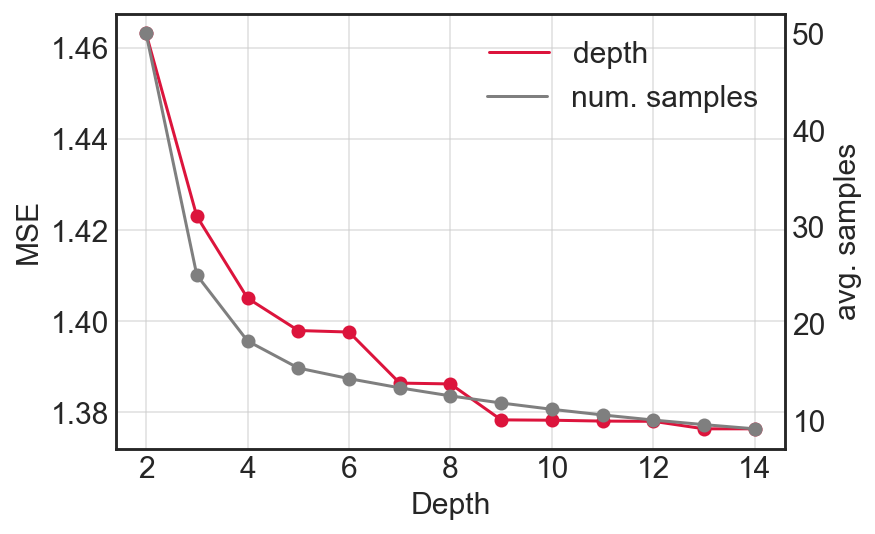

In [29]:
fig, host = plt.subplots()
par = host.twinx()

host.plot(depths, tree_mse, c="crimson", label="depth")
host.scatter(depths, tree_mse, c="crimson")
par.plot(depths, mean_samples, c="tab:gray", label="num. samples")
par.scatter(depths, mean_samples, c="tab:gray")
host.grid(alpha=0.6)
host.set_ylabel("MSE")
par.set_ylabel("avg. samples")
host.set_xlabel("Depth");
host.legend(bbox_to_anchor=(0.835, 1))
par.legend(bbox_to_anchor=(1, 0.9))

## References
* https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/splits.pdf
* https://github.com/jdmcpeek/pretty-print-binary-tree